<a href="https://colab.research.google.com/github/singhalkirtika/Simple_RNN_Pytorch/blob/master/Simple_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision


In [0]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

(21,)


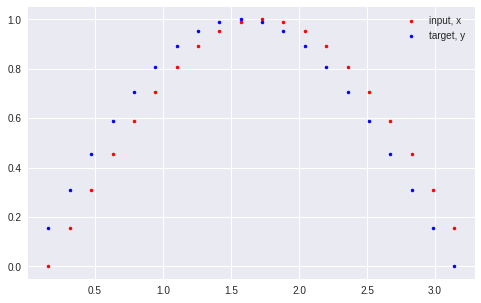

In [4]:
seq_length = 20

time_steps = np.linspace(0, np.pi, seq_length+1)
data = np.sin(time_steps)
print(data.shape)
data.resize((seq_length+1, 1))

x = data[:-1]
y = data[1:]

plt.figure(figsize=(8, 5))

plt.plot(time_steps[1:], x, 'r.', label="input, x")
plt.plot(time_steps[1:], y, 'b.', label="target, y")

plt.legend(loc="best")
plt.show()


In [0]:
class RNN(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, n_layers):
    super(RNN, self).__init__()
    
    self.hidden_dim = hidden_dim
    
    # define an RNN with specified parameters
    # batch_first means that the first dim of the input and output will be the batch_size
    self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
    
    # last, fully-connected layer
    self.fc = nn.Linear(hidden_dim, output_size)
    
  def forward(self, x, hidden):
    # x (batch_size, seq_length, input_size)
    # hidden (n_layers, batch_size, hidden_dim)
    # r_out (batch_size, time_step, hidden_size)
    batch_size = x.size(0)
    
    # get RNN outputs
    r_out, hidden = self.rnn(x, hidden)
    
    # shape output to be (batch_size*seq_length, hidden_dim)
    r_out = r_out.view(-1, self.hidden_dim)
    
    #get final layer
    output = self.fc(r_out)
    
    return output, hidden

In [6]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

# generate evenly spaced, test data pts
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


In [0]:
rnn = nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

In [23]:
print(output.shape)
print(hn.shape)

torch.Size([5, 3, 20])
torch.Size([2, 3, 20])


In [7]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [0]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

In [0]:
def train(rnn, n_steps, print_every):
  
  # initialize the hidden state
  hidden = None
  
  for step in range(75):
    # defining the training data 
    time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
    data = np.sin(time_steps)
    data.resize((seq_length + 1, 1)) # input_size=1
    
    x = data[:-1]
    y = data[1:]
    
    # convert data into Tensors
    x_tensor = torch.Tensor(x).unsqueeze(0)
    y_tensor = torch.Tensor(y)
    
    # outputs from the rnn
    prediction, hidden = rnn(x_tensor, hidden)
    
    ## Representing Memory ##
    # make a new variable for hidden and detach the hidden state from its history
    # this way, we don't backpropagate through the entire history
    
    hidden = hidden.data
    
    loss = criterion(prediction, y_tensor)
    # zero gradients
    optimizer.zero_grad()
    # perform backprop and update weights
    loss.backward()
    optimizer.step()
    
    # display loss and predictions
    if step%print_every == 0:        
      print('Loss: ', loss.item())
      plt.plot(time_steps[1:], x, 'r.') # input
      plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
      plt.show()
  return rnn

Loss:  0.001090907258912921


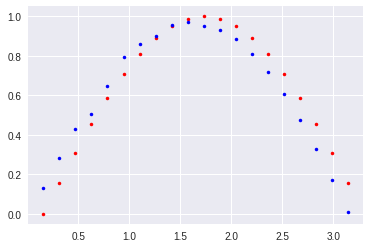

Loss:  0.00023483265249524266


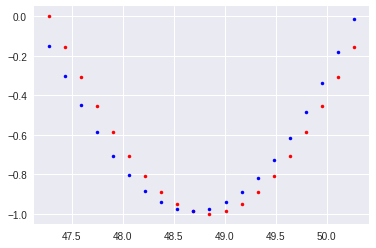

Loss:  0.00013251796190161258


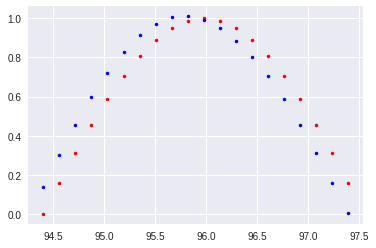

Loss:  5.577518095378764e-05


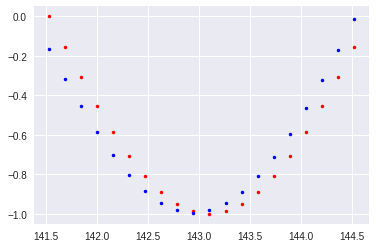

Loss:  4.032328797620721e-05


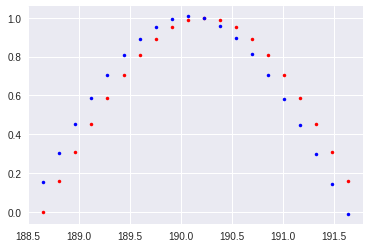

In [24]:
# train the rnn and monitor results
n_steps = 75
print_every = 15

trained_rnn = train(rnn, 75, print_every)